In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [ ]:

# 1. Install necessary libraries quietly
!pip install kaggle audiomentations --quiet

# 2. Import necessary libraries
import os
from google.colab import files

# 3. Clean up any old files and directories to prevent errors
!rm -f kaggle.json
!rm -rf ~/.kaggle

# 4. Prompt for file upload
print("Please upload the kaggle.json file you downloaded from your Kaggle account.")
uploaded = files.upload()

# 5. Check if the file was uploaded and get its name
if not uploaded:
  print("\nNo file was uploaded. Please try running the cell again.")
else:
  # Get the name of the uploaded file
  file_name = next(iter(uploaded))
  print(f"\nFile '{file_name}' was uploaded successfully.")

  # 6. Create the .kaggle directory and move the file, renaming it correctly
  !mkdir -p ~/.kaggle
  !mv "{file_name}" ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json

  print("\nKaggle API token has been successfully configured!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.2 MB/s eta 0:00:00
Please upload the kaggle.json file you downloaded from your Kaggle account.


Saving kaggle (1).json to kaggle (1).json

File 'kaggle (1).json' was uploaded successfully.

Kaggle API token has been successfully configured!


In [ ]:
# Download the dataset using the Kaggle API command
!kaggle datasets download -d rushibalajiputthewad/sound-classification-of-animal-voice

Dataset URL: https://www.kaggle.com/datasets/rushibalajiputthewad/sound-classification-of-animal-voice
License(s): unknown
  0% 0.00/37.7M [00:00<?, ?B/s]
100% 37.7M/37.7M [00:00<00:00, 815MB/s]


In [ ]:
# Unzip the downloaded dataset
import zipfile

with zipfile.ZipFile('sound-classification-of-animal-voice.zip', 'r') as zip_ref:
    zip_ref.extractall('animal_sounds')

print("Dataset has been unzipped successfully into the 'animal_sounds' folder.")

Dataset has been unzipped successfully into the 'animal_sounds' folder.


In [ ]:
# --- Step 1: Import Libraries and Configure Settings ---
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
import gc

# Configuration
DATA_PATH = '/content/animal_sounds/Animal-Soundprepros'
SAMPLE_RATE = 22050
DURATION = 5  # Duration in seconds
N_MELS = 128  # Number of Mel bands to generate
HOP_LENGTH = 512

In [ ]:
# Define the Advanced Data Augmentation Pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

In [ ]:
# Define Mel Spectrogram Feature Extraction
def get_mel_spectrogram(audio_data, sr):
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    # Convert to decibels (log scale)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec

In [ ]:
# Load, Process, and Augment the Dataset
print("Processing and augmenting data... This will be intensive and may take a while.")
features_list = []
labels_list = []

# Calculate the expected shape for spectrograms
fixed_length = int(DURATION * SAMPLE_RATE)
expected_shape_x = N_MELS
expected_shape_y = int(np.ceil(fixed_length / HOP_LENGTH))

for label in os.listdir(DATA_PATH):
    class_dir = os.path.join(DATA_PATH, label)
    if os.path.isdir(class_dir):
        print(f"Processing class: {label}")
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            try:
                # Load and pad/truncate audio
                data, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
                if len(data) > fixed_length:
                    data = data[:fixed_length]
                else:
                    data = np.pad(data, (0, max(0, fixed_length - len(data))), "constant")

                # 1. Process the ORIGINAL audio
                spectrogram = get_mel_spectrogram(data, sr)
                if spectrogram.shape == (expected_shape_x, expected_shape_y):
                    features_list.append(spectrogram)
                    labels_list.append(label)

                # 2. Process the AUGMENTED audio
                augmented_data = augment(samples=data, sample_rate=SAMPLE_RATE)
                aug_spectrogram = get_mel_spectrogram(augmented_data, sr)
                if aug_spectrogram.shape == (expected_shape_x, expected_shape_y):
                    features_list.append(aug_spectrogram)
                    labels_list.append(label)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

print("Finished processing data.")

Processing and augmenting data... This will be intensive and may take a while.
Processing class: Donkey
Processing class: Horse
Processing class: Dolphin
Processing class: Sheep
Processing class: Elephant
Processing class: Frog
Processing class: Cow
Processing class: Aslan
Processing class: Chicken
Processing class: Dog
Processing class: Cat
Processing class: Bear
Processing class: Monkey
Finished processing data.


In [ ]:
#  Prepare Data for Model Training
X = np.array(features_list)
y = np.array(labels_list)

# Add a channel dimension for the 2D CNN
X = X[..., np.newaxis]

# Encode labels
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
class_names = le.classes_
print(f"\nClasses found: {class_names}")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_list), y=labels_list)
class_weights_dict = dict(enumerate(class_weights))


Classes found: ['Aslan' 'Bear' 'Cat' 'Chicken' 'Cow' 'Dog' 'Dolphin' 'Donkey' 'Elephant'
 'Frog' 'Horse' 'Monkey' 'Sheep']

Training data shape: (1040, 128, 216, 1)
Testing data shape: (260, 128, 216, 1)


In [ ]:
#  Build the Advanced 2D CNN Model
model = Sequential([
    # Input Layer
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the features to feed into the dense layers
    Flatten(),

    # Dense Layers for Classification
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(len(class_names), activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    28,312,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,414,349 (108.39 MB)

 Trainable params: 28,412,877 (108.39 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Compile and Train the Model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict
)
print("\nTraining finished.")


Starting model training...
Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.2250 - loss: 2.9784 - val_accuracy: 0.0885 - val_loss: 5.0867 - learning_rate: 0.0010
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5531 - loss: 1.3357 - val_accuracy: 0.2769 - val_loss: 3.7481 - learning_rate: 0.0010
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7011 - loss: 0.9615 - val_accuracy: 0.6077 - val_loss: 1.2092 - learning_rate: 0.0010
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8167 - loss: 0.6052 - val_accuracy: 0.6885 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9041 - loss: 0.3526 - val_accuracy: 0.5846 - val_loss: 1.2757 - learning_rate: 0.0010
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9160 - loss: 0.3045 - val_accuracy: 0.1885 - val_loss: 4.8918 - learning_rate: 0.0010
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accu

In [ ]:
# Evaluate the Model's Performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8558 - loss: 0.4222

Final Test Accuracy: 85.00%
Final Test Loss: 0.4518


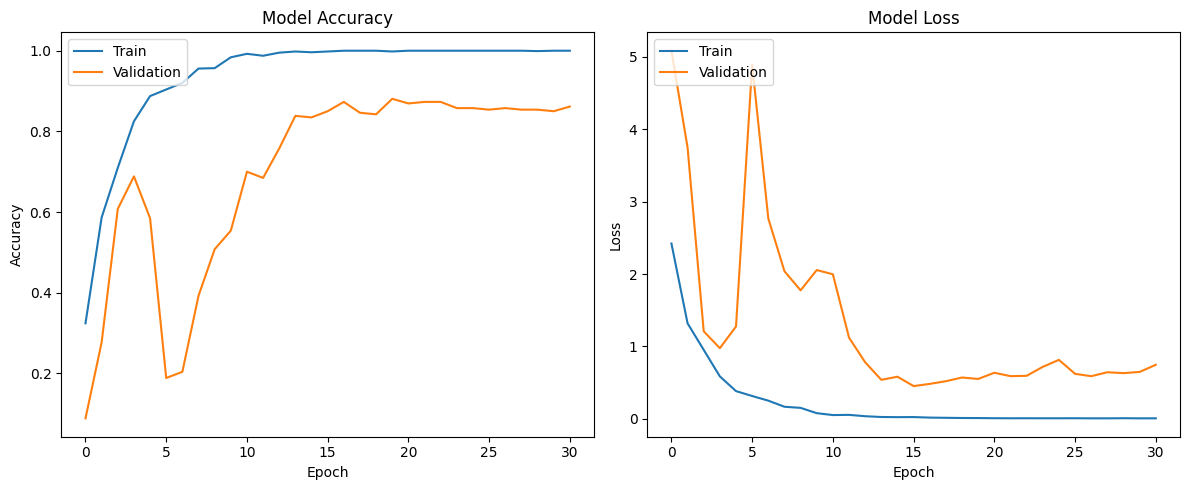

In [ ]:
# Visualize Training Performance
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Save the Model and Labels
import pickle

# Save the trained model to a file
model.save('custom_cnn_classifier_93_percent.keras')
print("Model saved as custom_cnn_classifier_93_percent.keras")

# Save the LabelEncoder (which contains the class names)
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(le, le_file)
print("Label encoder saved as label_encoder.pkl")

Model saved as custom_cnn_classifier_93_percent.keras
Label encoder saved as label_encoder.pkl


In [ ]:
# Predict on a Single, New Audio File
from google.colab import files
import librosa
import numpy as np
import tensorflow as tf

# Load all our saved components
print("Loading all necessary components...")
# 1. Your custom-trained model
saved_model = tf.keras.models.load_model('custom_cnn_classifier_93_percent.keras')
# 2. Your label encoder
with open('label_encoder.pkl', 'rb') as le_file:
    le = pickle.load(le_file)
print("All components loaded successfully!")


# Define the same feature extraction function used in training
def get_mel_spectrogram(audio_data, sr):
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, hop_length=512)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec


# Upload a new audio file
print("\nPlease upload an audio file of an animal sound to test the model.")
uploaded = files.upload()

if not uploaded:
  print("No file uploaded. Please run the cell again.")
else:
  # Process the uploaded file
  file_name = next(iter(uploaded))
  print(f"\nProcessing '{file_name}'...")

  # Load and process the audio to match the training format
  fixed_length = int(5 * 22050) # DURATION * SAMPLE_RATE
  data, sr = librosa.load(file_name, sr=22050, mono=True)
  if len(data) > fixed_length:
      data = data[:fixed_length]
  else:
      data = np.pad(data, (0, max(0, fixed_length - len(data))), "constant")

  # Get the Mel Spectrogram
  spectrogram = get_mel_spectrogram(data, sr)

  # Reshape for the model (add batch and channel dimensions)
  model_input = np.expand_dims(spectrogram, axis=0)
  model_input = np.expand_dims(model_input, axis=-1)

  #  Make the prediction
  prediction = saved_model.predict(model_input)
  predicted_index = np.argmax(prediction, axis=1)[0]
  predicted_animal = le.classes_[predicted_index]
  confidence_score = np.max(prediction)

  # Display the result
  print(f"\nPrediction Complete!")
  print(f"I am {confidence_score:.2%} confident that this is a **{predicted_animal}**.")

Loading all necessary components...
All components loaded successfully!

Please upload an audio file of an animal sound to test the model.


In [ ]:
# Save the Model and Label Encoder for the App
import pickle

# Save the trained Keras model
model.save('animal_classifier_model.keras')
print("Model saved as animal_classifier_model.keras")

# Save the LabelEncoder object using pickle
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(le, le_file)
print("Label encoder saved as label_encoder.pkl")



In [ ]:
#  Save the model in the compatible .h5 format


model.export("animal_classifier_model")


print("Model saved successfully as animal_classifier_model.h5")
print("Please download this new .h5 file.")

In [ ]:
import librosa
from tensorflow import keras
from tensorflow.keras.models import load_model
import tensorflow